In [1]:
import numpy as np
import pickle as pkl
from pprint import pprint
import os
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime
import pandas as pd

plt.ion()

In [2]:
dr='/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/2024May28 No window data /OneDrive_1_6-17-2024/Run_8_TBS_Experiment_ecr_results/'

In [3]:
os.chdir(dr)

In [7]:
dr1=dr+'230601 RUN 8 Wells 1-3'
dr2=dr+'230602 RUN 8 Wells 4-6'

filenames=os.listdir(dr1)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))

sorted_filenames_updated1=['230601 RUN 8 Wells 1-3/'+filename + '/data.raw_20240521_16h16m.pkl' for filename in sorted_filenames]

filenames=os.listdir(dr2)
filenames.remove('.DS_Store')
sorted_filenames = sorted(filenames, key=lambda x: int(x.split('#')[1].split()[0]))
sorted_filenames_updated2=['230602 RUN 8 Wells 4-6/'+filename + '/data.raw_20240521_16h16m.pkl' for filename in sorted_filenames]
sorted_filenames_updated=sorted_filenames_updated1+sorted_filenames_updated2

In [9]:
len(sorted_filenames_updated)

36

In [10]:
sorted_filenames_updated

['230601 RUN 8 Wells 1-3/#1 (baseline)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#2 (well #1 post stim 1)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#3 (well #1 post stim 2)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#4 (well #1 post stim 3)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#5 (well #1 post stim 4)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#6 (well #2 post stim 1)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#7 (well #2 post stim 2)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#8 (well #2 post stim 3)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#9 (well #2 post stim 4)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#10 (well #3 post stim 1)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#11 (well #3 post stim 2)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#12 (well #3 post stim 3)/data.raw_20240521_16h16m.pkl',
 '230601 RUN 8 Wells 1-3/#13 (well #

In [11]:
df = pd.read_csv('/Users/tianyichen/Desktop/Research /PhDresearch/Hopkins_Organoid/April 19 2024/Time-file.csv')
df['time'] = pd.to_datetime(df['Unnamed: 1'].astype(str) + ' ' + df['Unnamed: 2'].astype(str), errors='coerce')

for i in df.loc[df['Unnamed: 2'].isnull(),'time'].index:
    df.loc[i,'time'] = df.loc[i-1,'time']+pd.Timedelta(10,'min')

well=4
stimulus_time=df[df[str(well)]==True]['time']
time=df[df['Unnamed: 2'].notna()]['time']
time_diff = [(t - time[0]).total_seconds() / 60 for t in time]
stimulus_time_diff = [(t - time[0]).total_seconds() / 60 for t in stimulus_time]

In [22]:
len(time_diff)

36

In [14]:
def filter_matrix_TC(data, well):

    # Extract necessary data from the loaded data structure
    adj_matrix = data[well]['win_0']['adj_matrix_predicted']
    votes = data[well]['win_0']['votes']  # This variable is loaded but not used in the snippet you provided
    corr_peaks = data[well]['win_0']['corr_peaks']
    fs = data['config']['data']['fs']  # Sampling frequency

    # Initialize a matrix to track synchronization based on correlation peaks
    synced_matrix = np.full(adj_matrix.shape, False)
    for key in corr_peaks.keys():
        if np.all(np.abs(np.array(corr_peaks[key]['delays'])) < 1/fs):
            synced_matrix[key[0], key[1]] = True
            synced_matrix[key[1], key[0]] = True

    # Create the filtered matrix as per the given logic
    filtered_matrix = np.logical_and(adj_matrix, np.logical_not(synced_matrix))

    return filtered_matrix

In [81]:
well='well004'

In [82]:
all_adj = []
num_vertices = []
for i in range(len(sorted_filenames_updated)):
    with open(sorted_filenames_updated[i], 'rb') as f:
        data = pkl.load(f)
    adj = filter_matrix_TC(data, well)
    all_adj.append(adj)
    num_vertices.append(adj.shape[0])
    print(i,sum(sum(adj)), adj.shape[0] )


0 96213 978
1 96819 985
2 92734 981
3 101344 979
4 96448 985
5 98624 980
6 97909 982
7 98033 982
8 99039 987
9 86097 980
10 87633 977
11 103334 975
12 89411 982
13 88204 975
14 90776 981
15 103659 971
16 89383 968
17 93202 971
18 110125 951
19 115110 954
20 113750 955
21 114731 948
22 113954 952
23 103954 948
24 112391 950
25 113285 951
26 106023 940
27 111160 948
28 111785 949
29 107040 943
30 111342 949
31 102003 945
32 112142 954
33 102669 945
34 109333 952
35 108993 953


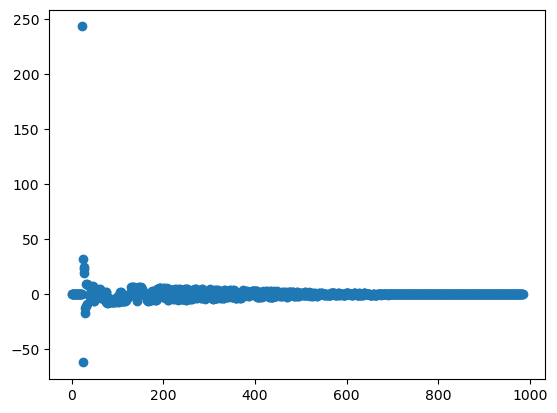

In [83]:
s,u=np.linalg.eig(all_adj[1])
plt.scatter(range(all_adj[1].shape[0]),s)

In [84]:
## add zeros to the adj mat such that they have the same dims 
dim = max(num_vertices) # Max number of vertices to determine dimension
m=len(all_adj)
adj_aug = np.zeros((m, dim, dim))  # Pre-allocate a zero matrix of the desired size
for i in range(m):
    ma = all_adj[i]  
    l = ma.shape[0]  
    adj_aug[i, :l, :l] = ma 

In [ ]:
graph_matching=False

from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline

count = len([x for x in time_diff if x < 400])
for i in range(0, count):
    adj_gm[i] = adj_aug[i]
    #print(time_diff[i])

## only match between two days
res = quadratic_assignment(adj_aug[count-1],adj_aug[count],options = {'maximize': True})
perm = res['col_ind']
adj_gm[count] = adj_aug[count][perm][:,perm]

for i in range(count, m):
    adj_gm[i] = adj_aug[i][perm][:,perm]
    #print(time_diff[i])


In [130]:
graph_matching=True

from scipy.optimize import quadratic_assignment
from numpy import linalg as LA
adj_gm=np.zeros([m,dim,dim])
adj_gm[0]=adj_aug[0] ## use the first graph as baseline
for i in range(1, m):
    res = quadratic_assignment(adj_gm[i-1],adj_aug[i],options = {'maximize': True})
    perm = res['col_ind']
    ofv=res['fun']
    fun_I = np.trace(adj_aug[i].T  @ adj_gm[i-1] )
    adj_gm[i]=adj_aug[i][perm][:,perm]
    before_norm = LA.norm(adj_aug[i] - adj_gm[i-1], 'fro')
    after_norm = LA.norm(adj_gm[i] - adj_gm[i-1], 'fro')

     # Printing the before and after norms to see the difference
    print(f"Frob diff before GM: {before_norm}, After GM: {after_norm},OFV before GM: {fun_I}, After GM: {ofv}")

Frob diff before GM: 416.4228620044774, After GM: 231.0930548502053,OFV before GM: 9812.0, After GM: 69814.0
Frob diff before GM: 404.3797719965726, After GM: 238.91211773369722,OFV before GM: 13015.0, After GM: 66237.0
Frob diff before GM: 403.2617016281115, After GM: 242.62316459893108,OFV before GM: 15729.0, After GM: 67606.0
Frob diff before GM: 419.2350176213814, After GM: 239.2112037509949,OFV before GM: 11017.0, After GM: 70285.0
Frob diff before GM: 388.2370409942874, After GM: 238.61684768683037,OFV before GM: 22172.0, After GM: 69067.0
Frob diff before GM: 394.07740356432515, After GM: 233.33023807470818,OFV before GM: 20618.0, After GM: 71045.0
Frob diff before GM: 411.4219245494824, After GM: 232.12927432790548,OFV before GM: 13337.0, After GM: 71029.0
Frob diff before GM: 417.50449099380955, After GM: 231.80595333166056,OFV before GM: 11381.0, After GM: 71669.0
Frob diff before GM: 387.25960285059426, After GM: 235.48672998706317,OFV before GM: 17583.0, After GM: 64841.0
F

In [150]:
## only consider the June 02 data and no matching

choosen_time_points=range(18,m)

prod=adj_gm[choosen_time_points[0]]
for i in (range(1,len(choosen_time_points))):
    prod=prod * adj_gm[choosen_time_points[i]]
    print(choosen_time_points[i], sum(sum(prod>0)))

19 77787
20 62532
21 52812
22 45586
23 37858
24 32866
25 29114
26 25208
27 21978
28 19790
29 17285
30 15630
31 13813
32 12602
33 11293
34 10212
35 9216


In [132]:
from graspologic.datasets import load_drosophila_right
from graspologic.plot import heatmap
from graspologic.utils import binarize, symmetrize
import graspologic.utils as graspologic_utils

In [151]:
## find the connected component for the common edge subgraph 
[a,ind]=graspologic_utils.largest_connected_component(prod,return_inds=True)
len(ind)
n=len(ind)
n

433

In [152]:
# double check every adj mat is connected 
glist=np.zeros([len(choosen_time_points),len(ind),len(ind)])
for i in range(len(choosen_time_points)):
    glist[i]=adj_gm[choosen_time_points[i]][ind][:,ind]
    print(graspologic_utils.is_fully_connected(glist[i]))

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


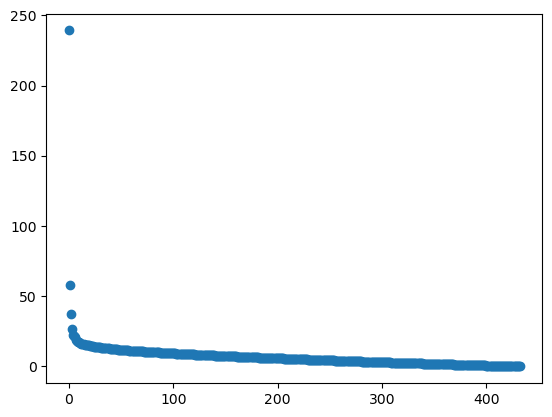

In [153]:
## scree plot for one graph 
u,s,v=np.linalg.svd(glist[0], full_matrices=True)
plt.scatter(range(n),s)

In [136]:
from graspologic.embed import AdjacencySpectralEmbed

In [154]:
tm=choosen_time_points

In [155]:
ed=1
Xhat_list=np.zeros([len(tm),n,2*ed])
for i in range(len(tm)):
    ase = AdjacencySpectralEmbed(n_components=ed)
    Xhat, Yhat = ase.fit_transform(glist[i])
    Xhat_list[i][:,list(np.arange(ed))]=Xhat
    Xhat_list[i][:,list(np.arange(ed,2*ed))]=Yhat

Text(0, 0.5, 'eigen value')

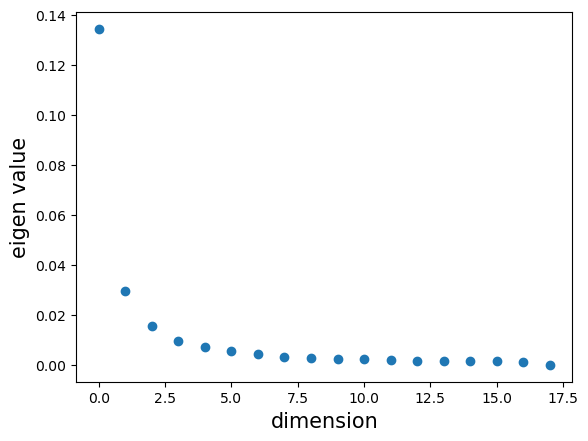

In [156]:
from scipy.linalg import orthogonal_procrustes
D=np.zeros([len(tm),len(tm)])

for i in range(len(tm)):
    for j in range(len(tm)):
        R, sca = orthogonal_procrustes(Xhat_list[i] , Xhat_list[j] )
        D[i,j]=LA.norm(Xhat_list[i] @ R -  Xhat_list[j],2)**2/n  

J=np.ones([len(tm),len(tm)])/len(tm)
I=np.eye(len(tm))
P=I-J

H=(-1/2)*P@D@P
w,v=LA.eig(H)
idx = w.argsort()[::-1]   
w = w[idx]
v = v[:,idx]
plt.scatter(range(len(tm)),w) 
#plt.title('scree plot for MDS')
plt.xlabel('dimension',fontsize=15)
plt.ylabel('eigen value',fontsize=15)

In [157]:
d=2
MDS=v[:,:d] @ np.diag(np.sqrt(w[:d]))

Text(0, 0.5, 'dim 2')

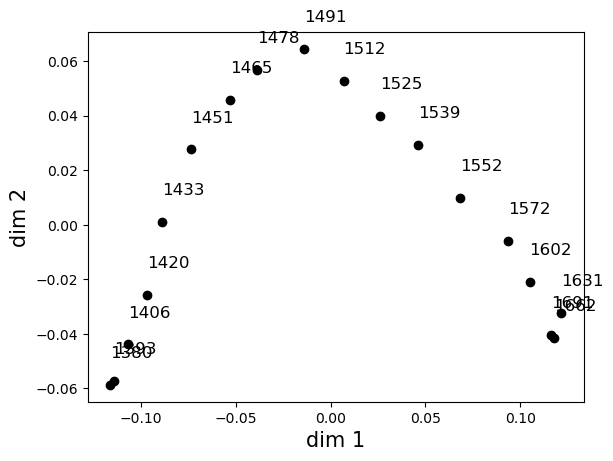

In [166]:
plt.scatter(MDS[:,0],-MDS[:,1],color='black')
for i in range(len(tm)):
    plt.text(MDS[i,0],-MDS[i,1]+0.01,int(time_diff[choosen_time_points[i]]), fontsize=12)
plt.xlabel("dim 1",fontsize=15)
plt.ylabel("dim 2",fontsize=15)

In [142]:
from sklearn.manifold import Isomap

In [159]:
embedding = Isomap(n_neighbors=3,n_components=1)
iso = embedding.fit_transform(MDS)

In [160]:
time = [time_diff[choosen_time_points[i]] for i in range(len(choosen_time_points))]

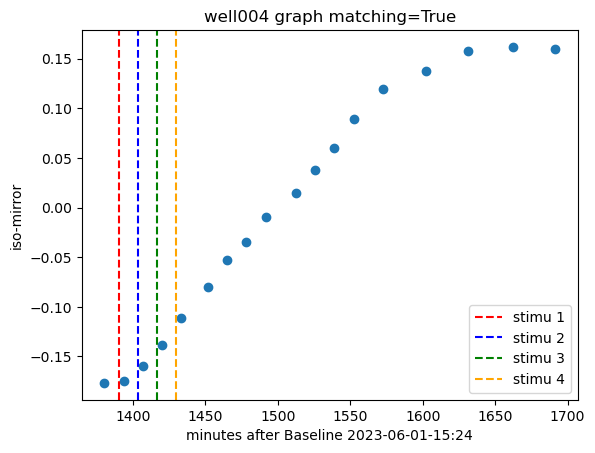

In [162]:

# Plot the scatter plot
plt.scatter(time,-iso)

# Add vertical lines
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

# Set the x-axis label and y-axis label
plt.xlabel('minutes after Baseline 2023-06-01-15:24')
plt.ylabel('iso-mirror')

# Add a title
plt.title(str(well)+' graph matching='+str(graph_matching))

# Add a legend
plt.legend()

# Show the plot
plt.show()


In [167]:
time

[1380.45,
 1393.6666666666667,
 1406.8833333333334,
 1420.1166666666666,
 1433.3666666666666,
 1451.8,
 1465.0833333333333,
 1478.3666666666666,
 1491.65,
 1512.6166666666666,
 1525.8666666666666,
 1539.1,
 1552.35,
 1572.4833333333333,
 1602.3333333333333,
 1631.4,
 1662.1166666666666,
 1691.5]

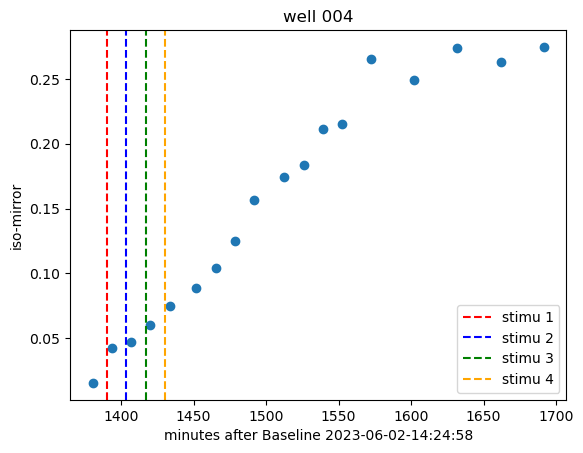

In [149]:
# Plot the scatter plot
plt.scatter(time[18:], -iso[18:])

# Add vertical lines
plt.axvline(x=stimulus_time_diff[0], color='red', linestyle='--', label='stimu 1')
plt.axvline(x=stimulus_time_diff[1], color='blue', linestyle='--', label='stimu 2')
plt.axvline(x=stimulus_time_diff[2], color='green', linestyle='--', label='stimu 3')
plt.axvline(x=stimulus_time_diff[3], color='orange', linestyle='--', label='stimu 4')

# Set the x-axis label and y-axis label
plt.xlabel('minutes after Baseline 2023-06-02-14:24:58')
plt.ylabel('iso-mirror')

# Add a title
plt.title('well 004')

# Add a legend
plt.legend()

# Show the plot
plt.show()
